# Get data

In [ ]:
# To run this notebook, follow the next steps:
# 1. You need to download the archive.zip file from https://www.kaggle.com/datasets/sonainjamil/bleached-corals-detection
# 2. Create a folder named 'Bleached_and_Unbleached_Corals_Classification/' inside the 'raw_data' folder
# 3. Copy the archive.zip file into the 'Bleached_and_Unbleached_Corals_Classification/' folder
# 4. Define the 'path_data' variable below with the path to the 'raw_data/Bleached_and_Unbleached_Corals_Classification/' folder on your local machine.

# path_data = '/Users/carloschutz/code/Lucia-Cordero/ReefSight-Project/raw_data/Bleached_and_Unbleached_Corals_Classification'

In [16]:
import os
import tensorflow as tf

data_dir = "/Users/carloschutz/code/Lucia-Cordero/ReefSight-Project/raw_data/Bleached_and_Unbleached_Corals_Classification:"

print("Contents of data_dir:", os.listdir(data_dir))
# Expect: ['Bleached', 'Unbleached'] (order may vary) (if showing other files, check the path or delete extraneous files)


Contents of data_dir: ['.DS_Store', 'Bleached', 'Unbleached']


In [1]:
import os, shutil, random
from glob import glob

random.seed(42)

# Root that currently contains Bleached/ and Unbleached/
data_dir = "/Users/carloschutz/code/Lucia-Cordero/ReefSight-Project/raw_data/Bleached_and_Unbleached_Corals_Classification:"   # ← CHANGE THIS

classes = ["Bleached", "Unbleached"]
splits = ["train", "val", "test"]
ratios = {"train": 0.8, "val": 0.1, "test": 0.1}

for cls in classes:
    src_dir = os.path.join(data_dir, cls)
    files = glob(os.path.join(src_dir, "*"))
    random.shuffle(files)

    n = len(files)
    n_train = int(ratios["train"] * n)
    n_val   = int(ratios["val"] * n)

    split_files = {
        "train": files[:n_train],
        "val":   files[n_train:n_train + n_val],
        "test":  files[n_train + n_val:],
    }

    for split in splits:
        dst_dir = os.path.join(data_dir, split, cls)
        os.makedirs(dst_dir, exist_ok=True)
        for f in split_files[split]:
            shutil.copy2(f, dst_dir)

print("Done. Created train/val/test folders under", data_dir)


Done. Created train/val/test folders under /Users/carloschutz/code/Lucia-Cordero/ReefSight-Project/raw_data/Bleached_and_Unbleached_Corals_Classification:


In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

image_size = (224, 224)
batch_size = 16
seed = 42

train_ds = image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    label_mode="binary",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = image_dataset_from_directory(
    os.path.join(data_dir, "val"),
    label_mode="binary",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = image_dataset_from_directory(
    os.path.join(data_dir, "test"),
    label_mode="binary",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 6991 files belonging to 2 classes.
Found 873 files belonging to 2 classes.
Found 876 files belonging to 2 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers

image_size = (224, 224)
input_shape = image_size + (3,)
learning_rate = 1e-4
num_classes = 2

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

def create_vgg16_model(input_shape, learning_rate=1e-4):
    inputs = layers.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = preprocess_input(x)

    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

vgg_model = create_vgg16_model(input_shape, learning_rate)
vgg_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ add[0][0]         │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(data_dir, "models", "vgg16_best.keras"),
        monitor="val_accuracy",
        save_best_only=True
    ),
]

history = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
)

test_loss, test_acc = vgg_model.evaluate(test_ds)


Epoch 1/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 429s 979ms/step - accuracy: 0.7282 - loss: 0.9647 - val_accuracy: 0.8843 - val_loss: 0.2902
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 406s 929ms/step - accuracy: 0.8561 - loss: 0.3650 - val_accuracy: 0.9038 - val_loss: 0.2380
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 380s 869ms/step - accuracy: 0.8828 - loss: 0.2799 - val_accuracy: 0.9187 - val_loss: 0.2112
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 378s 866ms/step - accuracy: 0.8941 - loss: 0.2431 - val_accuracy: 0.9210 - val_loss: 0.1988
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 377s 863ms/step - accuracy: 0.9117 - loss: 0.2104 - val_accuracy: 0.9278 - val_loss: 0.1985
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 376s 861ms/step - accuracy: 0.9172 - loss: 0.2022 - val_accuracy: 0.9244 - val_loss: 0.1897
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 376s 860ms/step - accuracy: 0.9163 - loss: 0.1905 - val_accuracy: 0.9278 - val_loss: 0.1777
Epoch 8/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 376s 860ms/step - accuracy: 0.9265 -

In [5]:
val_loss, val_acc = vgg_model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)


55/55 ━━━━━━━━━━━━━━━━━━━━ 46s 828ms/step - accuracy: 0.9530 - loss: 0.1519
Validation loss: 0.15188877284526825
Validation accuracy: 0.9530355334281921


In [6]:
test_loss, test_acc = vgg_model.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


55/55 ━━━━━━━━━━━━━━━━━━━━ 48s 865ms/step - accuracy: 0.9555 - loss: 0.1200
Test loss: 0.1199866235256195
Test accuracy: 0.9554794430732727


In [7]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extract true labels and predictions from tf.data.Dataset
def get_confusion_matrix(model, dataset):
    # Get true labels

    #x, y_true = np.concatenate([y.numpy() for x, y in dataset])

    y_pred = []
    y_true = []


    for x, y in dataset:
        pred = model.predict(x)
        pred = (pred > 0.5).astype(int).flatten()

        y_pred.extend(pred)
        y_true.extend(y.numpy().flatten())

    # Get predictions
    #y_pred = model.predict(dataset)
    #y_pred = (y_pred > 0.5).astype(int).flatten()

    print(y_true, y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    acc=accuracy_score(y_true, y_pred)
    prec=precision_score(y_true, y_pred)
    rec=recall_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

    return cm


# Plot confusion matrix
def plot_cm(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/

2025-12-11 21:23:11.049516: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


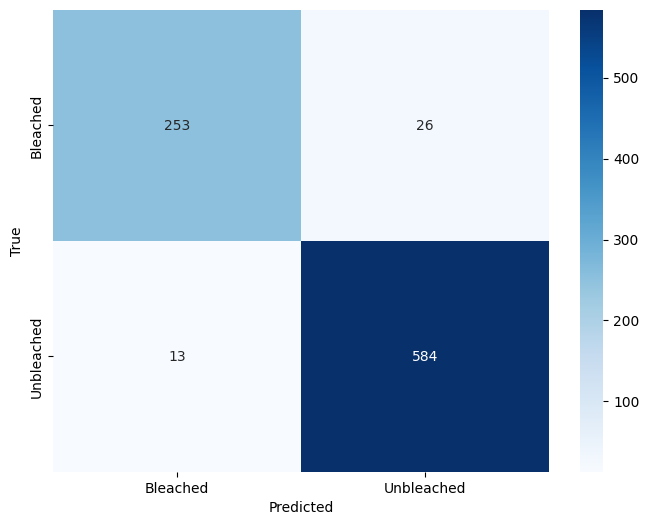

In [8]:
cm = get_confusion_matrix(vgg_model, test_ds)
class_names = ["Bleached", "Unbleached"]
plot_cm(cm, class_names=class_names)


In [25]:
y_pred = np.argmax(vgg_model.predict(test_ds), axis=1)
print(y_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


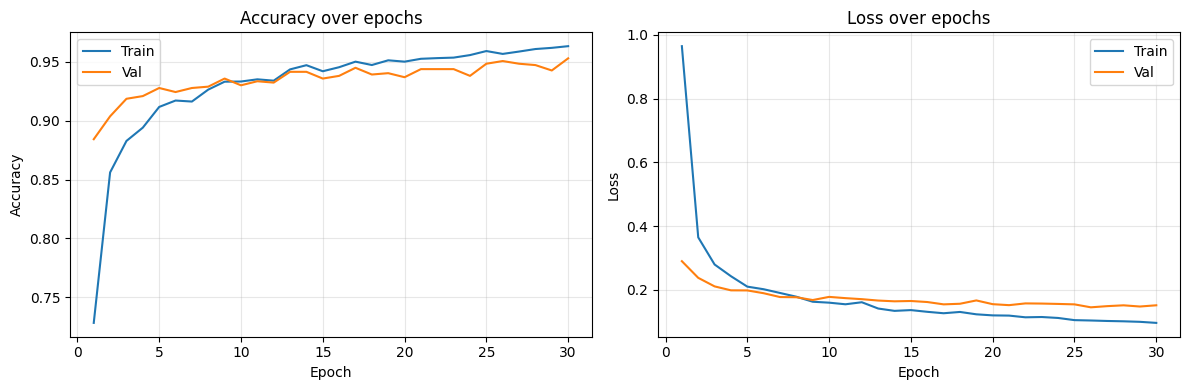

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    # Put history into a DataFrame for easier plotting
    df = pd.DataFrame(history.history)
    df["epoch"] = range(1, len(df) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(df["epoch"], df["accuracy"], label="Train")
    plt.plot(df["epoch"], df["val_accuracy"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(df["epoch"], df["loss"], label="Train")
    plt.plot(df["epoch"], df["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


/var/folders/pd/49tggkj16kj_jxk0fmm8f0b00000gn/T/ipykernel_66953/3973166095.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[idx].numpy())


True: Unbleached
Pred: Unbleached
Bleached probability: 0.00%
Unbleached probability: 100.00%


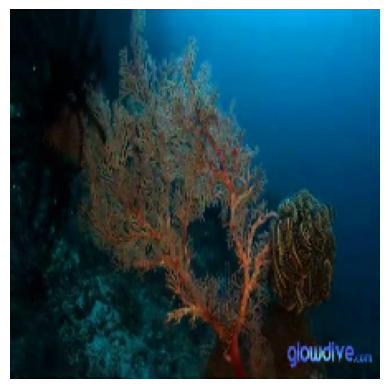

In [68]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os

best_model_path = os.path.join(data_dir, "models", "vgg16_best.keras")
model = tf.keras.models.load_model(best_model_path)


if 'class_names' not in globals():
    if hasattr(train_ds, "class_names"):
        class_names = train_ds.class_names
    else:
        class_names = sorted(
            [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
        )


images, labels = next(iter(test_ds))
idx = random.randint(0, len(images) - 1)
img = images[idx]
true_label = int(labels[idx].numpy())

prob = float(model.predict(tf.expand_dims(img, 0))[0, 0])  # P(class 1)
pred_label = int(prob >= 0.5)


bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
unbleached_idx = 1 - bleached_idx

if bleached_idx == 1:
    p_bleached = prob
else:
    p_bleached = 1 - prob

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(img.numpy().astype("uint8"))
plt.axis("off")
plt.show()


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def predict_folder(model, folder_path, class_names, threshold=0.5):
    """Predict all images in a folder"""

    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = []

    for file in os.listdir(folder_path):
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_files.append(os.path.join(folder_path, file))

    if not image_files:
        print(f"No images found in {folder_path}")
        return

    print(f"Found {len(image_files)} images")

    # Predict all images
    predictions = []
    true_labels = []  # if you have labels in same folder structure

    for img_path in image_files:
        # Load and preprocess
        img = keras_image.load_img(img_path, target_size=(224, 224))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, 0)
        x = preprocess_input(x)

        # Predict
        prob = model.predict(x, verbose=0)[0, 0]
        pred_label = int(prob >= threshold)

        # Map to class name
        bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
        p_bleached = prob if bleached_idx == 1 else 1 - prob

        predictions.append({
            'filename': os.path.basename(img_path),
            'pred_class': class_names[pred_label],
            'p_bleached': p_bleached,
            'confidence': max(p_bleached, 1-p_bleached)
        })

    return predictions


In [ ]:

# Usage
folder_path = "/Users/carloschutz/Downloads/Coral Reef Bleach Detection.v2i.multiclass/test"  # ← CHANGE THIS

predictions = predict_folder(vgg_model, folder_path, class_names)

# Print results
print("\nPredictions:")
for pred in predictions:
    print(f"{pred['filename']:<30} → {pred['pred_class']} ({pred['p_bleached']*100:.1f}% bleached)")

# Save to CSV
import pandas as pd
df = pd.DataFrame(predictions)
df.to_csv("predictions.csv", index=False)
print("\nSaved to predictions.csv")

# Optional: confusion matrix if you have ground truth
# (assumes folder has subfolders like test/Bleached/, test/Unbleached/)


Found 124 images

Predictions:
8YQ3TI4GQB27.jpg               → Unbleached (9.4% bleached)
QFZKO2O5O7M9.jpg               → Unbleached (7.5% bleached)
AAKYWZZGAI42.jpg               → Unbleached (30.3% bleached)
NML60F0JHXOG.jpg               → Unbleached (22.8% bleached)
QP6SVG5M3874.jpg               → Unbleached (0.3% bleached)
HJ3YX40HAEOS.jpg               → Unbleached (13.5% bleached)
4YOW7E7VL4NH.jpg               → Unbleached (12.3% bleached)
URD5VMSPLVNG.jpg               → Unbleached (15.4% bleached)
6V6CQFQSB2JT.jpg               → Unbleached (1.9% bleached)
CO916APNOSOL.jpg               → Unbleached (0.4% bleached)
DSH4Q0LPT1AU.jpg               → Unbleached (5.7% bleached)
ATHO66R992L6.jpg               → Unbleached (0.2% bleached)
4OA97GPXBMZ5.jpg               → Unbleached (5.6% bleached)
A64DQCVZR3T4.jpg               → Unbleached (29.9% bleached)
9RK98G0J254A.jpg               → Unbleached (0.0% bleached)
CKOMY5AXIMB6.jpg               → Unbleached (39.4% bleached)
EQ

In [16]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

def predict_folder_and_counts(model, folder_path, class_names, threshold=0.5):
    image_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    files = [f for f in os.listdir(folder_path)
             if f.lower().endswith(image_exts)]
    files = [os.path.join(folder_path, f) for f in files]

    if not files:
        print("No images found.")
        return [], {}

    counts = {cls: 0 for cls in class_names}
    predictions = []

    # Which index corresponds to “Bleached” in your training?
    bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1

    for path in files:
        img = keras_image.load_img(path, target_size=(224, 224))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, 0)
        x = preprocess_input(x)

        prob = float(model.predict(x, verbose=0)[0, 0])  # sigmoid
        # Map sigmoid output to "Bleached" probability, regardless of index order
        p_bleached = prob if bleached_idx == 1 else 1 - prob

        pred_label_idx = int(p_bleached >= threshold) if bleached_idx == 1 else int(p_bleached < threshold)
        pred_class = class_names[pred_label_idx]

        counts[pred_class] += 1
        predictions.append({
            "filename": os.path.basename(path),
            "pred_class": pred_class,
            "p_bleached": p_bleached,
        })

    # Print counts
    total = len(files)
    print(f"\nTotal images: {total}")
    for cls in class_names:
        print(f"{cls}: {counts[cls]}")

    return predictions, counts

# Use it
folder_path = "/Users/carloschutz/Downloads/Coral Reef Bleach Detection.v2i.multiclass/test"  # change this
predictions, counts = predict_folder_and_counts(vgg_model, folder_path, class_names)



Total images: 263
Bleached: 98
Unbleached: 165


In [19]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

def sort_folder_by_prediction(model, src_folder, dst_root, class_names, threshold=0.5):
    image_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    files = [f for f in os.listdir(src_folder)
             if f.lower().endswith(image_exts)]
    files = [os.path.join(src_folder, f) for f in files]

    if not files:
        print("No images found.")
        return

    # Ensure destination folders exist
    os.makedirs(dst_root, exist_ok=True)
    for cls in class_names:
        os.makedirs(os.path.join(dst_root, cls), exist_ok=True)

    counts = {cls: 0 for cls in class_names}

    bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1

    for path in files:
        img = keras_image.load_img(path, target_size=(224, 224))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, 0)
        x = preprocess_input(x)

        prob = float(model.predict(x, verbose=0)[0, 0])

        # Map to P(Bleached) independent of class index order
        p_bleached = prob if bleached_idx == 1 else 1 - prob

        # Decide predicted class index
        pred_idx = int(p_bleached >= threshold) if bleached_idx == 1 else int(p_bleached < threshold)
        pred_class = class_names[pred_idx]

        # Destination path
        dst_folder = os.path.join(dst_root, pred_class)
        dst_path = os.path.join(dst_folder, os.path.basename(path))

        shutil.copy2(path, dst_path)
        counts[pred_class] += 1

    # Print summary
    total = len(files)
    print(f"\nProcessed {total} images from: {src_folder}")
    for cls in class_names:
        print(f"{cls}: {counts[cls]} (copied to {os.path.join(dst_root, cls)})")

# Usage
src_folder = "/Users/carloschutz/Downloads/Coral Reef Bleach Detection.v2i.multiclass/train"          # folder to classify
dst_root   = "/Users/carloschutz/Downloads/Coral Reef Bleach Detection.v2i.multiclass"           # will create subfolders here

sort_folder_by_prediction(vgg_model, src_folder, dst_root, class_names)



Processed 10044 images from: /Users/carloschutz/Downloads/Coral Reef Bleach Detection.v2i.multiclass/train
Bleached: 4101 (copied to /Users/carloschutz/Downloads/Coral Reef Bleach Detection.v2i.multiclass/Bleached)
Unbleached: 5943 (copied to /Users/carloschutz/Downloads/Coral Reef Bleach Detection.v2i.multiclass/Unbleached)


# For applying filter


In [130]:
pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 86.2 MB/s  0:00:004.7 MB/s eta 0:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [140]:
import cv2
import numpy as np

def strong_channel_stretch(img_bgr):
    # img_bgr: uint8 BGR
    result = img_bgr.copy().astype(np.float32)
    for c in range(3):
        ch = result[:, :, c]
        min_val, max_val = np.percentile(ch, 1), np.percentile(ch, 99)  # clip extremes
        ch = (ch - min_val) * 255.0 / (max_val - min_val + 1e-8)
        ch = np.clip(ch, 0, 255)
        result[:, :, c] = ch
    return result.astype(np.uint8)


In [141]:
def load_and_correct(img_path, target_size=(224, 224)):
    bgr = cv2.imread(img_path)
    bgr = cv2.resize(bgr, target_size)

    # Stronger correction
    bgr_corr = strong_channel_stretch(bgr)

    rgb_corr = cv2.cvtColor(bgr_corr, cv2.COLOR_BGR2RGB)
    x = tf.keras.preprocessing.image.img_to_array(rgb_corr)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x, rgb_corr


In [142]:
def gray_world_then_stretch(img_bgr):
    # Step 1: gray‑world balance
    gw = img_bgr.astype(np.float32)
    b_avg, g_avg, r_avg = [np.mean(gw[:, :, c]) for c in range(3)]
    k = (b_avg + g_avg + r_avg) / 3.0
    gw[:, :, 0] *= k / (b_avg + 1e-8)
    gw[:, :, 1] *= k / (g_avg + 1e-8)
    gw[:, :, 2] *= k / (r_avg + 1e-8)
    gw = np.clip(gw, 0, 255).astype(np.uint8)

    # Step 2: per‑channel stretch
    return strong_channel_stretch(gw)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Predicted class: Unbleached
Bleached probability: 0.60%
Unbleached probability: 99.40%


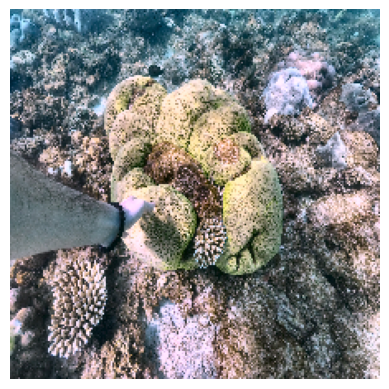

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1. Your color-correction function (unchanged)
def correct_underwater_color(image_bgr):
    """
    Gray World white balance + CLAHE contrast on BGR image.
    """
    B, G, R = cv2.split(image_bgr)

    avg_R = np.mean(R)
    avg_G = np.mean(G)
    avg_B = np.mean(B)
    avg_intensity = (avg_R + avg_G + avg_B) / 3.0

    gain_R = avg_intensity / (avg_R + 1e-8)
    gain_G = avg_intensity / (avg_G + 1e-8)
    gain_B = avg_intensity / (avg_B + 1e-8)

    R_corrected = np.clip(R * gain_R, 0, 255).astype(np.uint8)
    G_corrected = np.clip(G * gain_G, 0, 255).astype(np.uint8)
    B_corrected = np.clip(B * gain_B, 0, 255).astype(np.uint8)

    color_balanced_img = cv2.merge([B_corrected, G_corrected, R_corrected])

    # LAB + CLAHE for local contrast
    lab = cv2.cvtColor(color_balanced_img, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_corrected = clahe.apply(L)

    lab_corrected = cv2.merge([L_corrected, a, b])
    final_corrected_img = cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2BGR)

    return final_corrected_img

# 2. Helper to load, correct and prepare for your VGG16 model
def load_correct_and_prepare(img_path, target_size=(224, 224)):
    # Load BGR with OpenCV
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    bgr = cv2.resize(bgr, target_size)

    # Apply underwater correction
    bgr_corr = correct_underwater_color(bgr)

    # Convert to RGB for visualization / Keras
    rgb_corr = cv2.cvtColor(bgr_corr, cv2.COLOR_BGR2RGB)

    # To array and preprocess for VGG16
    x = image.img_to_array(rgb_corr)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x, rgb_corr

# 3. Use your already loaded model and class_names
# model = tf.keras.models.load_model(best_model_path)
# class_names = ['Bleached', 'Unbleached']  # or from train_ds.class_names

img_path = "/Users/carloschutz/code/Lucia-Cordero/ReefSight-Project/raw_data/Bleached_and_Unbleached_Corals_Classification:/Bleached/R0251.JPG"  # <- change this

x, vis_img = load_correct_and_prepare(img_path)
prob = float(model.predict(x)[0, 0])  # sigmoid output
pred_label = int(prob >= 0.5)

# Map bleached probability correctly
bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
if bleached_idx == 1:
    p_bleached = prob
else:
    p_bleached = 1 - prob

print("Predicted class:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(vis_img)
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
True: Bleached
Pred: Bleached
Bleached probability: 95.27%
Unbleached probability: 4.73%


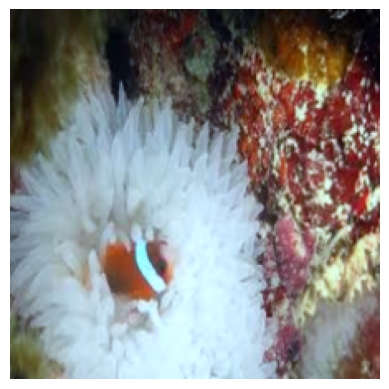

In [139]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_correct(img_path, target_size=(224, 224)):
    # Load with OpenCV (BGR)
    bgr = cv2.imread(img_path)
    bgr = cv2.resize(bgr, target_size)

    # Color correction
    bgr_corr = simple_white_balance(bgr)

    # Convert to RGB for Keras
    rgb_corr = cv2.cvtColor(bgr_corr, cv2.COLOR_BGR2RGB)

    # To array for model
    x = image.img_to_array(rgb_corr)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # same as you used with VGG16
    return x, rgb_corr

x, vis_img = load_and_correct("/Users/carloschutz/code/Lucia-Cordero/ReefSight-Project/raw_data/Bleached_and_Unbleached_Corals_Classification:/Bleached/214.png")
prob = model.predict(x)[0, 0]
pred_label = int(prob >= 0.5)

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(vis_img)
plt.axis("off")
plt.show()
